# Script d'implémentation du modèle Devstral 2 2512

On a deux façons d'utiliser un modèle pré-entrainé :
- via une API
- en local en loadant le modèle pré-entrainé (très coûteux en mémoire, nécessite des GPUs)

Workflow local :
1- Nettoyage et préparation des données textuelles
2- Loading du modèle pré-entraîné
3- définir le pipeline
4- définir le prompt de classification
5- exécution de l'inférence sur les données textuelles avec le modèle prentraîné
6- extraction des catégories prédites
7- évaluation des performances



Workflow API :
→ Construction du prompt
→ Requête API (POST)
→ Réponse texte
→ Extraction de la catégorie
→ Évaluation des performances


On utilisera l'API via le site openrouter.ai


In [64]:
# ----- Importation des bibliothèques nécessaires -----

import pandas as pd
import torch
import re
import transformers
from transformers import LlamaForCausalLM, LlamaTokenizer
from sklearn.metrics import classification_report, accuracy_score
import requests
import os
import json


## 1- Nettoyage et préparation des données textuelles

In [63]:
# ---- Chargement du dataset epuré ----
data = pd.read_csv('../Data/flipkart_cleaned.csv')
print(f"données textuelles descriptives du premier article :\n {data['description'].iloc[0]}",
      f"type de données : {type(data['description'].iloc[0])}")

données textuelles descriptives du premier article :
 Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curta

In [65]:
# ---- Nettoyage des données textuelles descriptives ----
def clean_text(text):
    # Convertir en minuscules
    text = text.lower()
    # Supprimer les balises HTML
    text = re.sub(r'<.*?>', '', text)
    # Supprimer la ponctuation et les caractères spéciaux
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Supprimer les espaces supplémentaires
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [66]:
data['description'] = data['description'].apply(clean_text)
print(f"données textuelles descriptives du premier article après nettoyage :\n {data['description'].iloc[0]}")

données textuelles descriptives du premier article après nettoyage :
 key features of elegance polyester multicolor abstract eyelet door curtain floral curtainelegance polyester multicolor abstract eyelet door curtain 213 cm in height pack of 2 price rs 899 this curtain enhances the look of the interiorsthis curtain is made from 100 high quality polyester fabricit features an eyelet style stitch with metal ringit makes the room environment romantic and lovingthis curtain is ant wrinkle and anti shrinkage and have elegant apparancegive your home a bright and modernistic appeal with these designs the surreal attention is sure to steal hearts these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening you create the most special moments of joyous beauty given by the soothing prints bring home the elegant curtai

In [67]:
# Sauvegarde du dataset nettoyé et préparé
data.to_csv('../Data/flipkart_prepared.csv', index=False)

In [68]:
data.head()

,uniq_id,product_name,description,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,key features of elegance polyester multicolor ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,specifications of sathiyas cotton bath towel 3...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,key features of eurospa cotton terry face towe...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,key features of santosh royal fashion cotton p...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,key features of jaipur print cotton floral kin...,Home Furnishing


In [69]:
categories =  list(data['product_category'].unique())
print(f"Catégories uniques dans le dataset : {categories}")

Catégories uniques dans le dataset : ['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']


## Workflow API

In [70]:
# ----- API KEY OpenRouter.ai -----
# MISTRAL_API_KEY = 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
os.environ["OPENROUTER_API_KEY"] = "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"
print(os.getenv("OPENROUTER_API_KEY"))

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


In [71]:
# ----- construction du prompt pour la classification -----
def build_prompt(desc, labels):
    return (
        "Tu es un classificateur de produits.\n"
        "Choisis UNE SEULE catégorie parmi : "
        + ", ".join(labels)
        + "\nRéponds uniquement par le nom exact de la catégorie.\n\n"
        f"Produit : {desc}"
    )

In [72]:
# ----- configuration des paramètres ------
API_KEY = os.getenv("OPENROUTER_API_KEY")
API_URL = "https://openrouter.ai/api/v1/chat/completions"
MODEL = "mistralai/devstral-2512:free"
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

In [73]:
# ----- fonction pour faire des prédictions  -----
def get_category_from_openrouter(description, categories):
    prompt = build_prompt(description, categories)
    data = {
        "model": MODEL,
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ]
    }
    response = requests.post(API_URL, headers=headers, json=data)
    response.raise_for_status()
    return response.json()["choices"][0]["message"]["content"]

In [45]:
# ----- exemple d'utilisation -----
sample_description = data['description'].iloc[30]
predicted_category = get_category_from_openrouter(sample_description, categories)

In [46]:
predicted_category

'Watches'

In [74]:
# ----- echantillonnage du dataset -----
sample_data = data.sample(n=100, random_state=42)

In [75]:
sample_data

,uniq_id,product_name,description,product_category
352,833a87b0af3b84fe246d2ebf271af177,Zyxel PLA-4205,buy zyxel pla4205 only for rs 8100 from flipka...,Computers
689,55195de3873fffaa9e37b041533d7305,Philips 9.5 W LED B22 3000K A55 IND Bulb,buy philips 95 w led b22 3000k a55 ind bulb fo...,Kitchen & Dining
485,44b963eb856b4831dfdd21b666593c95,Lapguard Lenovo IdeaPad V470 6 Cell Laptop Bat...,lapguard lenovo ideapad v470 6 cell laptop bat...,Computers
388,98ad5b99ad96695568d8f143b11ab740,Anna Andre Paris Set of Dark Fire & Numero 1 D...,flipkartcom buy anna andre paris set of dark f...,Beauty and Personal Care
31,29b1ca231e10d5269516b80bf9d0dffc,"Lenco Bdblue Tango Analog Watch - For Men, Boys",lenco bdblue tango analog watch for men boys b...,Watches
...,...,...,...,...
837,28e3f1e490cfc4b47bfb50671ff93283,Casotec Plexible LED Light 275012 Led Light US...,buy casotec plexible led light 275012 led ligh...,Computers
732,2bf95e5f8c4d7d0126de92e476d4fc8b,Sonpra Baby Boy's Bodysuit,sonpra baby boys bodysuit price rs 570 100 cot...,Baby Care
568,f559fdabbcc1f4980f215f847bfdd589,Flippd FD15102 Analog Watch - For Men,flippd fd15102 analog watch for men buy flippd...,Watches
260,04f9f818e2d657b873b07578cfe2eade,Monil Cow With Calf Showpiece - 10.2 cm,buy monil cow with calf showpiece 102 cm for r...,Home Decor & Festive Needs


In [76]:
# ------ inférence sur le csv echantillonné -----
import time
predictions = []
for i, desc in enumerate(sample_data["description"]):
    print(f"Classification produit {i+1}/{len(sample_data)}")
    pred = get_category_from_openrouter(desc, categories)
    predictions.append(pred)
    time.sleep(0.5)  # pour limiter le débit et rester dans le quota free

sample_data["predicted_category"] = predictions

Classification produit 1/100
Classification produit 2/100
Classification produit 3/100
Classification produit 4/100
Classification produit 5/100
Classification produit 6/100
Classification produit 7/100
Classification produit 8/100
Classification produit 9/100
Classification produit 10/100
Classification produit 11/100
Classification produit 12/100
Classification produit 13/100
Classification produit 14/100
Classification produit 15/100
Classification produit 16/100
Classification produit 17/100
Classification produit 18/100
Classification produit 19/100
Classification produit 20/100
Classification produit 21/100
Classification produit 22/100
Classification produit 23/100
Classification produit 24/100
Classification produit 25/100
Classification produit 26/100
Classification produit 27/100
Classification produit 28/100
Classification produit 29/100
Classification produit 30/100
Classification produit 31/100
Classification produit 32/100
Classification produit 33/100
Classification prod

In [53]:
# ----- sauvegarde des résultats -----
sample_data.to_csv('../Data/flipkart_sampled_with_predictions.csv', index=False)

In [54]:
sample_data

,uniq_id,product_name,description,product_category,predicted_category
352,833a87b0af3b84fe246d2ebf271af177,Zyxel PLA-4205,buy zyxel pla4205 only for rs 8100 from flipka...,Computers,Computers
689,55195de3873fffaa9e37b041533d7305,Philips 9.5 W LED B22 3000K A55 IND Bulb,buy philips 95 w led b22 3000k a55 ind bulb fo...,Kitchen & Dining,Home Decor & Festive Needs
485,44b963eb856b4831dfdd21b666593c95,Lapguard Lenovo IdeaPad V470 6 Cell Laptop Bat...,lapguard lenovo ideapad v470 6 cell laptop bat...,Computers,Computers
388,98ad5b99ad96695568d8f143b11ab740,Anna Andre Paris Set of Dark Fire & Numero 1 D...,flipkartcom buy anna andre paris set of dark f...,Beauty and Personal Care,Beauty and Personal Care
31,29b1ca231e10d5269516b80bf9d0dffc,"Lenco Bdblue Tango Analog Watch - For Men, Boys",lenco bdblue tango analog watch for men boys b...,Watches,Watches
...,...,...,...,...,...
837,28e3f1e490cfc4b47bfb50671ff93283,Casotec Plexible LED Light 275012 Led Light US...,buy casotec plexible led light 275012 led ligh...,Computers,Home Decor & Festive Needs
732,2bf95e5f8c4d7d0126de92e476d4fc8b,Sonpra Baby Boy's Bodysuit,sonpra baby boys bodysuit price rs 570 100 cot...,Baby Care,Baby Care
568,f559fdabbcc1f4980f215f847bfdd589,Flippd FD15102 Analog Watch - For Men,flippd fd15102 analog watch for men buy flippd...,Watches,Watches
260,04f9f818e2d657b873b07578cfe2eade,Monil Cow With Calf Showpiece - 10.2 cm,buy monil cow with calf showpiece 102 cm for r...,Home Decor & Festive Needs,Home Decor & Festive Needs


Accuracy: 0.8400
                            precision    recall  f1-score   support

                 Baby Care       1.00      0.82      0.90        11
  Beauty and Personal Care       1.00      0.86      0.92         7
                 Computers       1.00      0.86      0.93        22
Home Decor & Festive Needs       0.46      1.00      0.63        13
           Home Furnishing       1.00      0.60      0.75        20
          Kitchen & Dining       1.00      0.87      0.93        15
                   Watches       0.92      1.00      0.96        12

                  accuracy                           0.84       100
                 macro avg       0.91      0.86      0.86       100
              weighted avg       0.92      0.84      0.85       100



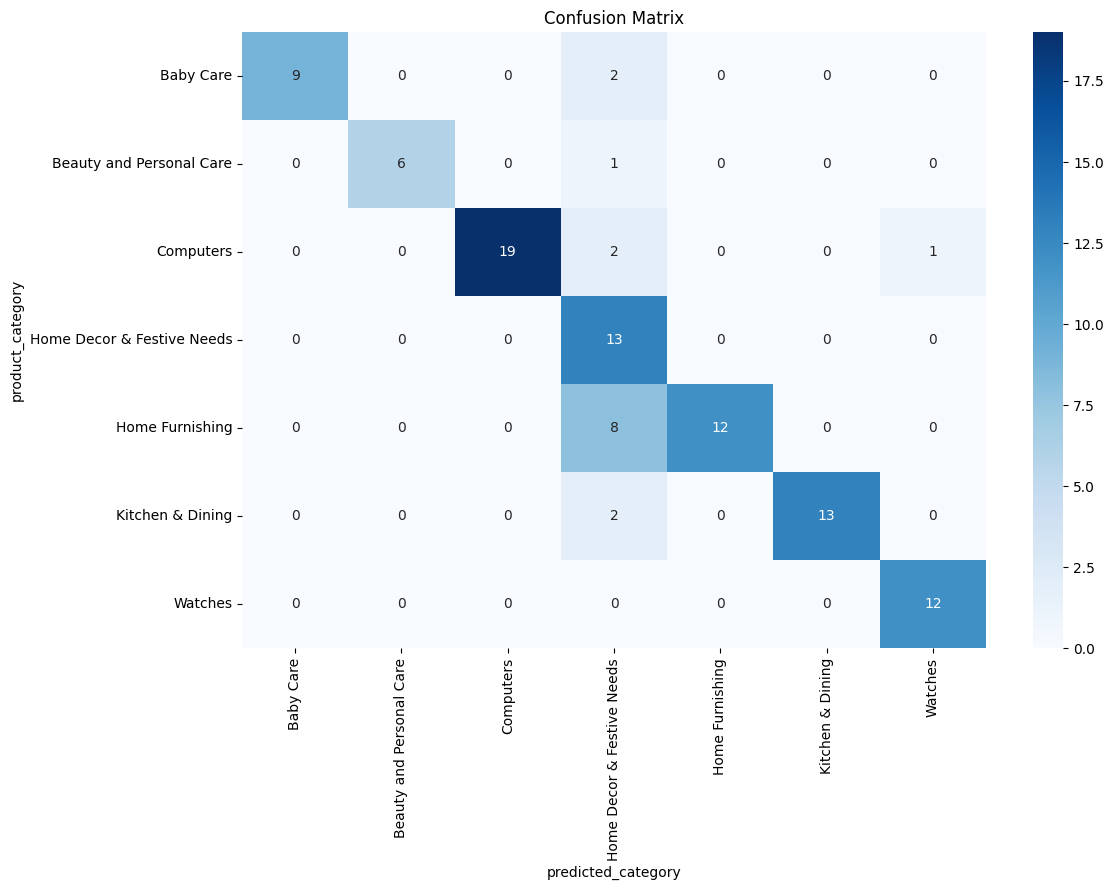

In [55]:
# ----- évaluation des performances -----
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# loading des résultats sauvegardés
results = pd.read_csv('../Data/flipkart_sampled_with_predictions.csv')
# déclaration des variables y_true et y_pred
y_true = results['product_category']
y_pred = results['predicted_category']
# calcul et affichage des métriques
accuracy_score = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_score:.4f}")
print(classification_report(y_true, y_pred))
# matrice de confusion
confusion_mtx = pd.crosstab(y_true, y_pred) 
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


précision = % de prédictions correctes parmi celles faites pour la classe

rappel = % d'exemples d'une classe correctement retrouvés

f1-score = Moyenne harmonique de précision et rappel (équilibre)

In [77]:
prompt_expl = f"""
Tu es un classificateur de produits.
Classe ce produit dans 7 catégories :
{', '.join(categories)}
Texte produit : {sample_description}

Explique en quelques phrases quels mots ou phrases du texte t'ont le plus aidé à prendre ta décision.
"""
explanation = get_category_from_openrouter(prompt_expl, categories)
print(explanation)

**Watches**

Les mots clés qui m'ont aidé à classer ce produit sont :
- "marvel dw100243 digital watch" (mention explicite d'une montre)
- "watch for boys girls" (confirme qu'il s'agit d'un accessoire de type montre)
- "buckle clasp", "multicolor strap", "contemporary dial" (détails typiques d'une montre).

Ces éléments indiquent clairement qu'il s'agit d'un produit de la catégorie **Watches**.
